<a href="https://colab.research.google.com/github/fikrifaizz/hr-attrition-optimizer/blob/main/notebooks/feature_engineering_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
df = pd.read_parquet("../data/processed/hr_cleaned.parquet")
print(f"Data Loaded. Shape: {df.shape}")

Data Loaded. Shape: (1470, 31)


In [3]:
X = df.drop(columns=['attrition']) # Gunakan lowercase sesuai hasil ETL
y = df['attrition']

print(f"Jumlah Churn (1): {y.sum()} ({y.mean():.2%})")

Jumlah Churn (1): 237 (16.12%)


In [4]:
# Encoding Kategorikal (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)
print(f"Shape setelah Encoding: {X_encoded.shape}")

# Split Train-Test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_encoded.columns)

print("Preprocessing Selesai.")

Shape setelah Encoding: (1470, 44)
Preprocessing Selesai.


In [12]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'solver': ['liblinear', 'lbfgs'],     
    'class_weight': ['balanced']          
}

logreg_base = LogisticRegression(random_state=42, max_iter=2000)
grid_search = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid,
    cv=5,                
    scoring='recall',    
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

best_logreg = grid_search.best_estimator_

print("\n--- HASIL TUNING LOGREG ---")
print(f"Parameter Terbaik: {grid_search.best_params_}")
print(f"Recall Terbaik di Training (CV): {grid_search.best_score_:.2%}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- HASIL TUNING LOGREG ---
Parameter Terbaik: {'C': 0.001, 'class_weight': 'balanced', 'solver': 'liblinear'}
Recall Terbaik di Training (CV): 82.63%


In [13]:
y_pred = best_logreg.predict(X_test_scaled)
y_prob = best_logreg.predict_proba(X_test_scaled)[:, 1]

print("\n--- FINAL REPORT (TEST SET) ---")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob):.4f}")


--- FINAL REPORT (TEST SET) ---
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       247
           1       0.26      0.79      0.40        47

    accuracy                           0.62       294
   macro avg       0.60      0.69      0.56       294
weighted avg       0.83      0.62      0.67       294

AUC-ROC Score: 0.7726


/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_51142/2592340014.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pd.concat([coeffs.head(5), coeffs.tail(5)]),


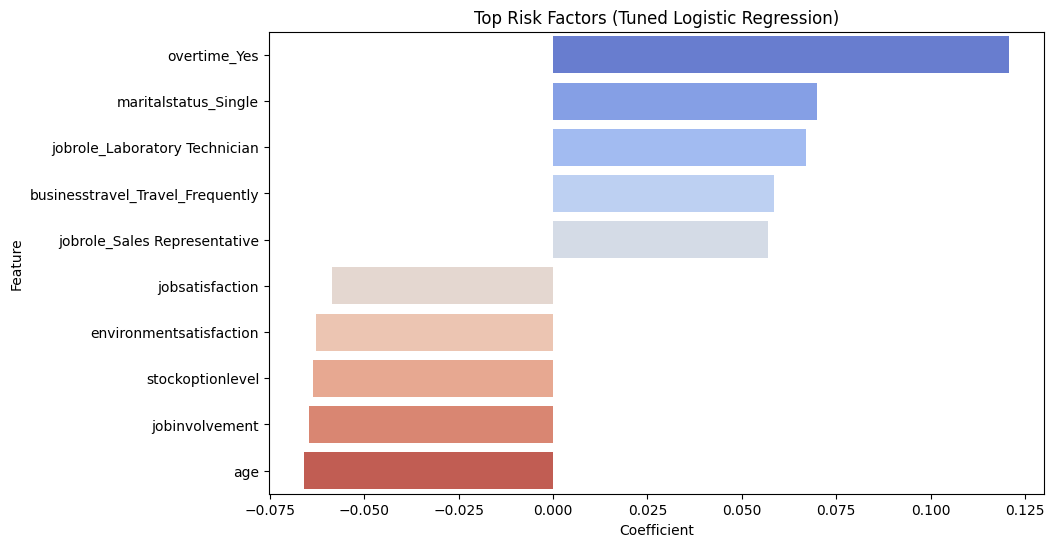

In [14]:
coeffs = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': best_logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
# Plot Top 5 Positif & Top 5 Negatif
sns.barplot(data=pd.concat([coeffs.head(5), coeffs.tail(5)]), 
            y='Feature', x='Coefficient', palette='coolwarm')
plt.title("Top Risk Factors (Tuned Logistic Regression)")
plt.show()